In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [7]:
# Memuat dataset
df = pd.read_csv("../Dataset/compressed_data.csv.gz", compression='gzip')
print(df.head())
df['Cover_Type'] -= 1

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

In [9]:
# Memisahkan kolom Cover_Type
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

In [13]:
# Melakukan scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Memisahkan dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Mengubah dataset menjadi tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [16]:
# Membuat DataLoader
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [17]:
# Membuat model dengan PyTorch
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# Contoh model
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = MLPModel(input_size, num_classes)

In [19]:
# Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Melatih model dengan PyTorch
def train_pytorch_model(model, dataloader_train, epochs=10):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in dataloader_train:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

train_pytorch_model(model, dataloader_train)

In [22]:
# Konversi dataset ke TensorFlow
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [23]:
# Definisi model dengan TensorFlow
def build_tf_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# Buat dan latih model dengan TensorFlow
tf_model = build_tf_model(X_train.shape[1], num_classes)
history = tf_model.fit(X_train_tf, y_train_tf, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


c:\Users\Azka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11621/11621 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.7305 - loss: 0.6359 - val_accuracy: 0.7779 - val_loss: 0.5160
Epoch 2/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.7877 - loss: 0.4909 - val_accuracy: 0.8042 - val_loss: 0.4614
Epoch 3/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8064 - loss: 0.4516 - val_accuracy: 0.8143 - val_loss: 0.4397
Epoch 4/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8192 - loss: 0.4258 - val_accuracy: 0.8253 - val_loss: 0.4196
Epoch 5/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.8283 - loss: 0.4097 - val_accuracy: 0.8314 - val_loss: 0.4031
Epoch 6/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8336 - loss: 0.3969 - val_accuracy: 0.8343 - val_loss: 0.3980
Epoch 7/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.8380 - loss: 0.3853 - val_accuracy: 0.8359 - val_loss: 0.3926
Epoch 8/10
11621/11621 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.8419 - lo

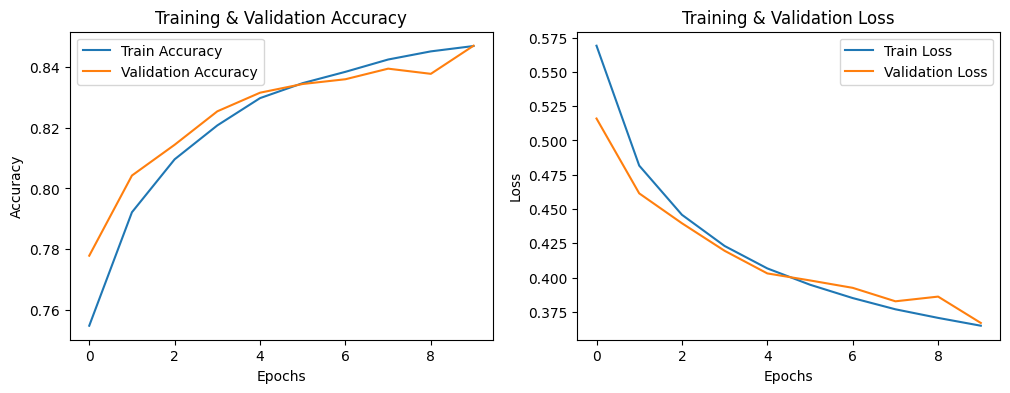

In [25]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [26]:
# Evaluasi dan kalkulasi metrik
model.eval()
y_pred_pytorch = []
y_true_pytorch = []
with torch.no_grad():
    for X_batch, y_batch in dataloader_test:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_pytorch.extend(predicted.numpy())
        y_true_pytorch.extend(y_batch.numpy())

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


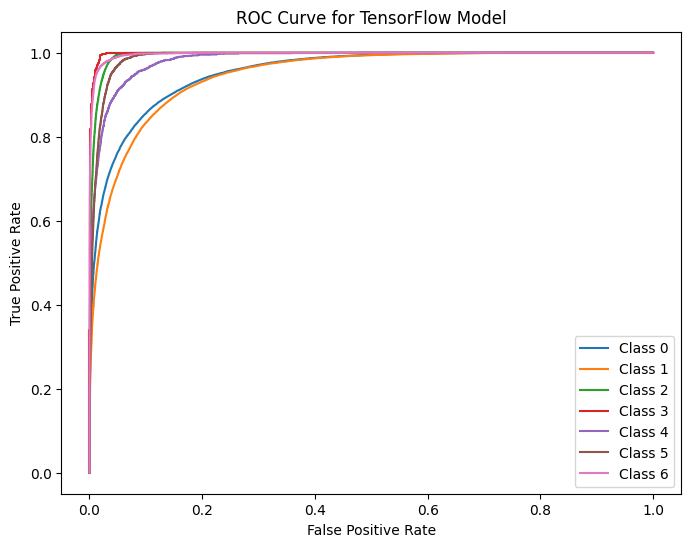

PyTorch Model Metrics:
Accuracy: 0.8542980818051169
Precision: 0.8546162815246877
Recall: 0.8542980818051169
F1 Score: 0.8529328271539773
AUC: 0.8596417573289303


In [27]:
# Visualisasi ROC untuk tensorflow
y_pred_proba_tf = tf_model.predict(X_test_tf)
dummies_y_test = pd.get_dummies(y_test)

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(dummies_y_test.iloc[:, i], y_pred_proba_tf[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for TensorFlow Model')
plt.legend()
plt.show()

accuracy = accuracy_score(y_true_pytorch, y_pred_pytorch)
precision = precision_score(y_true_pytorch, y_pred_pytorch, average='weighted')
recall = recall_score(y_true_pytorch, y_pred_pytorch, average='weighted')
f1 = f1_score(y_true_pytorch, y_pred_pytorch, average='weighted')
auc = roc_auc_score(pd.get_dummies(y_true_pytorch), pd.get_dummies(y_pred_pytorch), multi_class='ovr')

print(f"PyTorch Model Metrics:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nAUC: {auc}")

# Penjelasan Persamaan Matematika dalam Model MLP

## 1. Normalisasi Data
```
X' = (X - mean(X)) / std(X)
```
Normalisasi dilakukan dengan mengurangi setiap nilai fitur dengan rata-ratanya dan membaginya dengan standar deviasi. Ini bertujuan untuk memastikan semua fitur memiliki skala yang serupa agar model dapat lebih cepat belajar.

## 2. Forward Propagation di Model MLP

### 2.1. Lapisan Pertama
```
Z1 = W1 * X + b1
A1 = ReLU(Z1)
```
- `Z1` adalah hasil perkalian bobot `W1` dengan input `X`, ditambah bias `b1`.
- `A1` adalah output dari aktivasi ReLU, yang mengubah nilai negatif menjadi nol.

### 2.2. Lapisan Kedua
```
Z2 = W2 * A1 + b2
A2 = ReLU(Z2)
```
- `Z2` dihitung dengan cara yang sama seperti `Z1`.
- `A2` adalah hasil aktivasi menggunakan fungsi ReLU.

### 2.3. Lapisan Output
```
Z3 = W3 * A2 + b3
Y_hat = Softmax(Z3)
```
- `Z3` adalah hasil perhitungan bobot dan bias dari lapisan terakhir.
- `Y_hat` adalah hasil dari fungsi aktivasi softmax, yang mengubah hasil menjadi probabilitas untuk setiap kelas.

## 3. Fungsi Loss
```
Loss = -Σ y_true * log(Y_hat)
```
Fungsi loss yang digunakan adalah `cross-entropy loss`, yang mengukur seberapa jauh prediksi dari label yang sebenarnya.

## 4. Backpropagation
```
W = W - lr * dL/dW
b = b - lr * dL/db
```
- `dL/dW` dan `dL/db` adalah gradien loss terhadap bobot dan bias.
- `lr` adalah learning rate yang menentukan seberapa besar perubahan bobot.
- Bobot dan bias diperbarui untuk mengurangi loss.

## 5. Evaluasi Model

### 5.1. Akurasi

Accuracy = (Jumlah Prediksi Benar) / (Total Data)

### 5.2. Presisi
```
Precision = TP / (TP + FP)
```
### 5.3. Recall
```
Recall = TP / (TP + FN)
```
### 5.4. F1 Score
```
F1 = 2 * (Precision * Recall) / (Precision + Recall)
```
### 5.5. AUC-ROC

- AUC (Area Under Curve) menunjukkan seberapa baik model membedakan kelas.
- ROC (Receiver Operating Characteristic) menggambarkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

## 6. Kesimpulan
Model MLP menggunakan serangkaian transformasi linear dan aktivasi non-linear untuk mempelajari pola dalam data. Evaluasi dilakukan dengan metrik akurasi, presisi, recall, F1-score, dan AUC-ROC.

